
# Chapter 8 -> Spark ETL with Lakehouse | Apache HUDI

Task to do 
1. Read data from MySQL server into Spark
2. Create HIVE temp view from data frame
3. Load filtered data into HUDI format (create initial table)
4. Load filtered data again into HUDI format into same table 
5. Read HUDI tables using Spark data frame
6. Create Temp HIVE of HUDI tables
7. Write query to read data from HUDI 


In [1]:
# First Load all the required library and also Start Spark Session
# Load all the required library
from pyspark.sql import SparkSession

In [2]:
#Start Spark Session
spark = SparkSession.builder.appName("chapter8")\
        .config('spark.jars.packages', 'org.apache.hudi:hudi-spark3.2-bundle_2.12:0.13.0,mysql:mysql-connector-java:8.0.32')\
        .config('spark.sql.extensions', 'org.apache.spark.sql.hudi.HoodieSparkSessionExtension')\
        .config('spark.sql.catalog.spark_catalog', 'org.apache.spark.sql.hudi.catalog.HoodieCatalog')\
        .config('spark.serializer', 'org.apache.spark.serializer.KryoSerializer')\
        .config('spark.sql.catalog.local.warehouse','warehouse')\
        .getOrCreate()

sqlContext = SparkSession(spark)
#Dont Show warning only error
spark.sparkContext.setLogLevel("ERROR")

:: loading settings :: url = jar:file:/opt/spark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
org.apache.hudi#hudi-spark3.2-bundle_2.12 added as a dependency
mysql#mysql-connector-java added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-41dd8471-013c-4f80-affb-37d96c87fc6d;1.0
	confs: [default]
	found org.apache.hudi#hudi-spark3.2-bundle_2.12;0.13.0 in central
	found mysql#mysql-connector-java;8.0.32 in central
	found com.mysql#mysql-connector-j;8.0.32 in central
	found com.google.protobuf#protobuf-java;3.21.9 in central
:: resolution report :: resolve 455ms :: artifacts dl 25ms
	:: modules in use:
	com.google.protobuf#protobuf-java;3.21.9 from central in [default]
	com.mysql#mysql-connector-j;8.0.32 from central in [default]
	mysql#mysql-connector-java;8.0.32 from central in [default]
	org.apache.hudi#hudi-spark3.2-bundle_2.12;0.13.0 from central in [default]
	---------------------------------------------------------------------
	|              

1. Read data from MySQL server into Spark

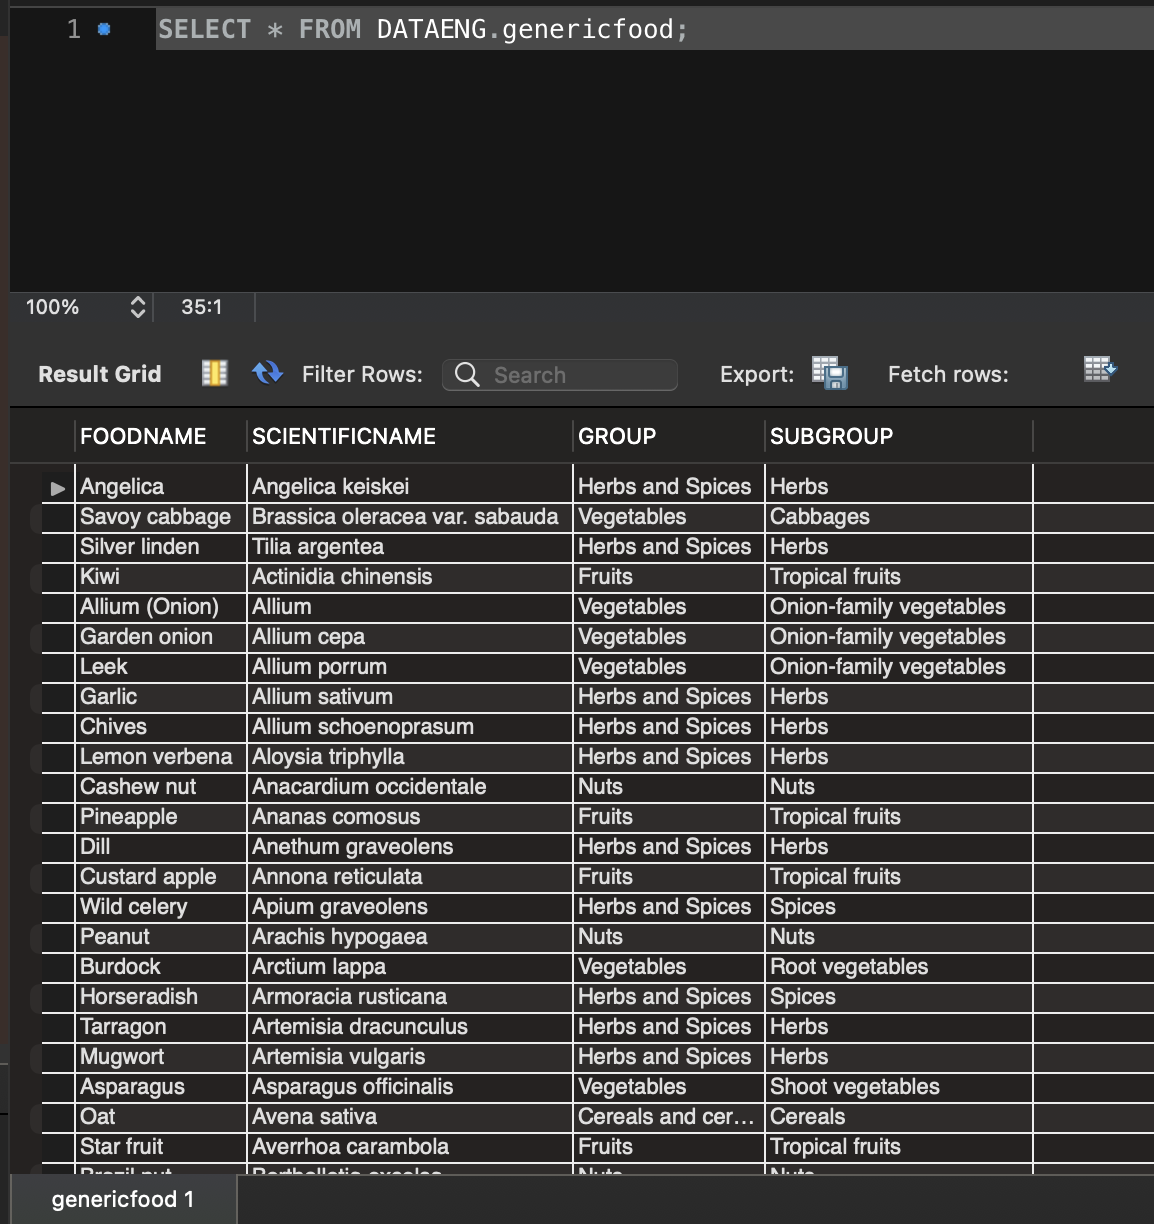


In [3]:
#Load CSV file into DataFrame
mysqldf = spark.read \
    .format("jdbc") \
    .option("driver","com.mysql.cj.jdbc.Driver") \
    .option("url", "jdbc:mysql://192.168.1.104:3306/DATAENG") \
    .option("dbtable", "genericfood") \
    .option("user", "root") \
    .option("password", "mysql") \
    .load()

In [4]:
#Checking dataframe schema
mysqldf.printSchema()

root
 |-- FOODNAME: string (nullable = true)
 |-- SCIENTIFICNAME: string (nullable = true)
 |-- GROUP: string (nullable = true)
 |-- SUBGROUP: string (nullable = true)



In [5]:
mysqldf.show(n=10)

+--------------+--------------------+----------------+--------------------+
|      FOODNAME|      SCIENTIFICNAME|           GROUP|            SUBGROUP|
+--------------+--------------------+----------------+--------------------+
|      Angelica|    Angelica keiskei|Herbs and Spices|               Herbs|
| Savoy cabbage|Brassica oleracea...|      Vegetables|            Cabbages|
| Silver linden|      Tilia argentea|Herbs and Spices|               Herbs|
|          Kiwi| Actinidia chinensis|          Fruits|     Tropical fruits|
|Allium (Onion)|              Allium|      Vegetables|Onion-family vege...|
|  Garden onion|         Allium cepa|      Vegetables|Onion-family vege...|
|          Leek|       Allium porrum|      Vegetables|Onion-family vege...|
|        Garlic|      Allium sativum|Herbs and Spices|               Herbs|
|        Chives|Allium schoenoprasum|Herbs and Spices|               Herbs|
| Lemon verbena|   Aloysia triphylla|Herbs and Spices|               Herbs|
+-----------

2. Create HIVE temp view from data frame

In [6]:
mysqldf.createOrReplaceTempView("tempFood")

3. Load filtered data into HUDI format (create initial table)

In [7]:
sqlContext.sql("SELECT * FROM tempFood").show(n=20)

+--------------+--------------------+----------------+--------------------+
|      FOODNAME|      SCIENTIFICNAME|           GROUP|            SUBGROUP|
+--------------+--------------------+----------------+--------------------+
|      Angelica|    Angelica keiskei|Herbs and Spices|               Herbs|
| Savoy cabbage|Brassica oleracea...|      Vegetables|            Cabbages|
| Silver linden|      Tilia argentea|Herbs and Spices|               Herbs|
|          Kiwi| Actinidia chinensis|          Fruits|     Tropical fruits|
|Allium (Onion)|              Allium|      Vegetables|Onion-family vege...|
|  Garden onion|         Allium cepa|      Vegetables|Onion-family vege...|
|          Leek|       Allium porrum|      Vegetables|Onion-family vege...|
|        Garlic|      Allium sativum|Herbs and Spices|               Herbs|
|        Chives|Allium schoenoprasum|Herbs and Spices|               Herbs|
| Lemon verbena|   Aloysia triphylla|Herbs and Spices|               Herbs|
|    Cashew 

In [8]:
sqlContext.sql("SELECT GROUP,count(*) FROM tempFood GROUP BY 1 ORDER BY 2 DESC").show(truncate=False)

+---------------------------+--------+
|GROUP                      |count(1)|
+---------------------------+--------+
|Herbs and Spices           |52      |
|Fruits                     |43      |
|Vegetables                 |31      |
|Nuts                       |11      |
|Pulses                     |9       |
|Cereals and cereal products|6       |
|Gourds                     |5       |
|Coffee and coffee products |3       |
|Teas                       |1       |
|Soy                        |1       |
+---------------------------+--------+



In [9]:
newdf = sqlContext.sql("SELECT *,now() as ts FROM tempFood WHERE GROUP = 'Herbs and Spices'")

In [10]:
newdf.count()

52

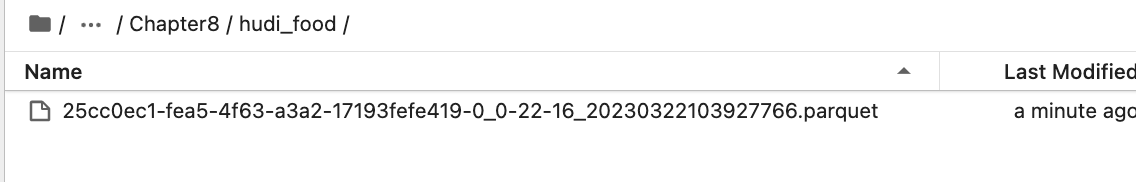

In [ ]:
hudi_options = {'hoodie.table.name': 'hudi_food','hoodie.datasource.write.recordkey.field': 'FOODNAME'}
basePath = "/opt/spark/SparkETL/Chapter8/hudi_food"

newdf.write.format("hudi"). \
    options(**hudi_options). \
    mode("append"). \
    save(basePath)

4. Load filtered data again into HUDI format into same table 

In [15]:
newdf1 = sqlContext.sql("SELECT *,now() as ts FROM tempFood WHERE GROUP = 'Fruits'")

In [16]:
basePath = "/opt/spark/SparkETL/Chapter8/hudi_food"

newdf1.write.format("hudi"). \
    options(**hudi_options). \
    mode("append"). \
    save(basePath)


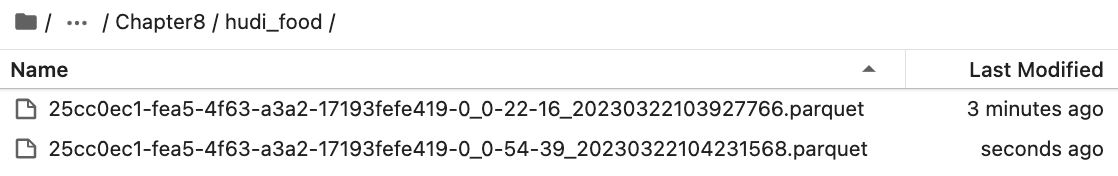

5. Read HUDI tables using Spark data frame

In [17]:
#Load delta file into DataFrame
hudidf = spark.read.format("hudi").load(basePath)

In [18]:
hudidf.printSchema()

root
 |-- _hoodie_commit_time: string (nullable = true)
 |-- _hoodie_commit_seqno: string (nullable = true)
 |-- _hoodie_record_key: string (nullable = true)
 |-- _hoodie_partition_path: string (nullable = true)
 |-- _hoodie_file_name: string (nullable = true)
 |-- FOODNAME: string (nullable = true)
 |-- SCIENTIFICNAME: string (nullable = true)
 |-- GROUP: string (nullable = true)
 |-- SUBGROUP: string (nullable = true)
 |-- ts: timestamp (nullable = false)



In [19]:
hudidf.show()

+-------------------+--------------------+------------------+----------------------+--------------------+----------------+--------------------+----------------+-------------+--------------------+
|_hoodie_commit_time|_hoodie_commit_seqno|_hoodie_record_key|_hoodie_partition_path|   _hoodie_file_name|        FOODNAME|      SCIENTIFICNAME|           GROUP|     SUBGROUP|                  ts|
+-------------------+--------------------+------------------+----------------------+--------------------+----------------+--------------------+----------------+-------------+--------------------+
|  20230322103927766|20230322103927766...|            Chives|                      |25cc0ec1-fea5-4f6...|          Chives|Allium schoenoprasum|Herbs and Spices|        Herbs|2023-03-22 10:39:...|
|  20230322103927766|20230322103927766...|        Lemon balm|                      |25cc0ec1-fea5-4f6...|      Lemon balm| Melissa officinalis|Herbs and Spices|        Herbs|2023-03-22 10:39:...|
|  20230322103927766

6. Create Temp HIVE of HUDI tables

In [20]:
hudidf.createOrReplaceTempView("tempHUDI")

7. Write query to read data from iceberg

In [21]:
sqlContext.sql("SELECT * FROM tempHUDI").show()

+-------------------+--------------------+------------------+----------------------+--------------------+----------------+--------------------+----------------+-------------+--------------------+
|_hoodie_commit_time|_hoodie_commit_seqno|_hoodie_record_key|_hoodie_partition_path|   _hoodie_file_name|        FOODNAME|      SCIENTIFICNAME|           GROUP|     SUBGROUP|                  ts|
+-------------------+--------------------+------------------+----------------------+--------------------+----------------+--------------------+----------------+-------------+--------------------+
|  20230322103927766|20230322103927766...|            Chives|                      |25cc0ec1-fea5-4f6...|          Chives|Allium schoenoprasum|Herbs and Spices|        Herbs|2023-03-22 10:39:...|
|  20230322103927766|20230322103927766...|        Lemon balm|                      |25cc0ec1-fea5-4f6...|      Lemon balm| Melissa officinalis|Herbs and Spices|        Herbs|2023-03-22 10:39:...|
|  20230322103927766

In [22]:
sqlContext.sql("SELECT count(*) FROM tempHUDI").show()

+--------+
|count(1)|
+--------+
|      95|
+--------+



In [23]:
sqlContext.sql("SELECT DISTINCT(SUBGROUP) FROM tempHUDI").show()

+---------------+
|       SUBGROUP|
+---------------+
|         Citrus|
|   Other fruits|
|  Oilseed crops|
|Tropical fruits|
|         Spices|
|          Herbs|
|         Drupes|
|          Pomes|
|        Berries|
+---------------+



In [24]:
sqlContext.sql("SELECT SUBGROUP,count(*) FROM tempHUDI GROUP BY SUBGROUP ORDER BY 2 DESC ").show()

+---------------+--------+
|       SUBGROUP|count(1)|
+---------------+--------+
|          Herbs|      33|
|        Berries|      13|
|         Spices|      13|
|Tropical fruits|      13|
|  Oilseed crops|       6|
|         Drupes|       6|
|         Citrus|       5|
|          Pomes|       4|
|   Other fruits|       2|
+---------------+--------+

